In [46]:
import sys
import json
import pandas as pd
import numpy as np
import os
from pathlib import Path
from importlib.machinery import SourceFileLoader
import api_client
from api_client import *
import random
import math
from statistics import mean
from statistics import stdev
import time
from collections import Counter
from sklearn import metrics
from sklearn.linear_model import PassiveAggressiveClassifier
import math
#api_client = SourceFileLoader("module.name", "../api_client.py").load_module()

DATA_DIR = '/home/solvvy/nmt_data/Upwork/'
SOLUTIONS_FILE = ''.join([DATA_DIR, 'solutions_org'])
QUERIES_FILE   = ''.join([DATA_DIR, 'queries_org'])
CAUCUSES_FILE  = ''.join([DATA_DIR, 'caucuses_org'])
def create_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
    return

def read(filename):
    print('Loading from file ', filename, '...')
    with open(filename) as data_file:
        return data_file.read().splitlines()
    
def read_padded(filename, MAX_LENGTH):
    print('Loading from file ', filename, '...')
    with open(filename) as data_file:
        data= data_file.read().splitlines()
        
    return [pad(item, MAX_LENGTH) for item in data ]

def pad(sentence,maxlength):
    LEN = len(sentence.split(' '))
    if LEN>=maxlength:
        return sentence[:maxlength]
    else:
        return ' '.join([sentence]+['BUFFER_PAD']*(maxlength-LEN))
    
def length_distribution( solutions_caucus):
    return [len(u.split(' ')) for u in solutions_caucus]


def print_dist(x):
    print('min:',min(x),'mean:',sum(x)/len(x),'max:',max(x))
    
def coocurrence_q_a(queries, solutions, vocab_words):
    start_time = time.time()
    coocurrence_vocab = []
    for i, (query,solution) in  enumerate(zip(queries, solutions)):
        gen = {'\t'.join((x, y)) for x in set(query.split(' ')) 
                      for y in set(solution.split(' ')) 
                      if x in vocab_words and y in vocab_words}
        coocurrence_vocab.append(Counter(gen))
        if i%1000 == 0:
            print('done with, i =', i,'in', time.time() - start_time,'seconds') 
    return coocurrence_vocab

def intersection_q_a(queries, solutions, vocab_words):
    # Identical to Chasm paper
    start_time = time.time()
    coocurrence_vocab = []
    for i, (query,solution) in  enumerate(zip(queries, solutions)):
        start_time1 = time.time()
        qq, aa = Counter(query.split()), Counter(solution.split())
        #print('1', time.time() - start_time1,'seconds') 
        qq_norm = math.sqrt( sum(map(lambda x:x*x, qq.values())))
        aa_norm = math.sqrt( sum(map(lambda x:x*x, aa.values())))
        gen = {key: (value*aa[key])/(qq_norm*aa_norm) for key,value in qq.items() if key in aa.keys()}

        coocurrence_vocab.append(gen)
        #print('2', time.time() - start_time2,'seconds') 
        if i%1000 == 0:
            print('done with, i =', i,'in', time.time() - start_time,'seconds') 
    return coocurrence_vocab

In [2]:
queries = read(''.join([DATA_DIR,'train/sources.tok']))
solutions = read(''.join([DATA_DIR,'train/targets.tok']))

vocab_queries = read(''.join([DATA_DIR,'train/vocab.sources.tok']))
vocab_solutions = read(''.join([DATA_DIR,'train/vocab.targets.tok']))
vocab_queries_filtered = [row.split('\t')[0] for row in vocab_queries]
vocab_solutions_filtered = [row.split('\t')[0] for row in vocab_solutions]

# read caucus positive negative
queries_caucus_positive = read(''.join([DATA_DIR, 'caucus_positive/sources.tok']))
solutions_caucus_positive = read(''.join([DATA_DIR,'caucus_positive/targets.tok']))
queries_caucus_negative = read(''.join([DATA_DIR,'caucus_negative/sources.tok']))
solutions_caucus_negative = read(''.join([DATA_DIR, 'caucus_negative/targets.tok']))

solutions_random = solutions.copy()
random.shuffle(solutions_random)

Loading from file  /home/solvvy/nmt_data/Upwork/train/sources.tok ...
Loading from file  /home/solvvy/nmt_data/Upwork/train/targets.tok ...
Loading from file  /home/solvvy/nmt_data/Upwork/train/vocab.sources.tok ...
Loading from file  /home/solvvy/nmt_data/Upwork/train/vocab.targets.tok ...
Loading from file  /home/solvvy/nmt_data/Upwork/caucus_positive/sources.tok ...
Loading from file  /home/solvvy/nmt_data/Upwork/caucus_positive/targets.tok ...
Loading from file  /home/solvvy/nmt_data/Upwork/caucus_negative/sources.tok ...
Loading from file  /home/solvvy/nmt_data/Upwork/caucus_negative/targets.tok ...


In [3]:
# Loading vocabulary
vocab = Counter()
sentence = []
for sentence in queries_caucus_positive:
    vocab.update(sentence.split(' '))
for sentence in solutions_caucus_positive:
    vocab.update(sentence.split(' '))
for sentence in solutions_caucus_negative:
    vocab.update(sentence.split(' '))
for sentence in queries:
    vocab.update(sentence.split(' '))
for sentence in solutions:
    vocab.update(sentence.split(' '))

print('Vocabulary length',len(vocab),'word at 20k',vocab.most_common(20000)[-1])  
vocab_words = dict(vocab.most_common(10000)).keys()

Vocabulary length 208533 word at 20k ('Bhavna', 6)


# Discriminative model for Unigram co-occurance. It is very high dimensional and not sufficiently sparse.

In [6]:
coocurrence_vocab_positive = coocurrence_q_a(queries, solutions, vocab_words)
coocurrence_vocab_negative = coocurrence_q_a(queries, solutions_random, vocab_words)
coocurrence_vocab_caucus_positive = coocurrence_q_a(queries_caucus_positive, 
                                                    solutions_caucus_positive, 
                                                    vocab_words)
coocurrence_vocab_caucus_negative = coocurrence_q_a(queries_caucus_negative, 
                                                    solutions_caucus_negative, 
                                                    vocab_words)


done with, i = 0 in 0.004544258117675781 seconds
done with, i = 1000 in 1.6310405731201172 seconds
done with, i = 2000 in 3.202805280685425 seconds
done with, i = 3000 in 4.754812002182007 seconds
done with, i = 4000 in 6.2600417137146 seconds
done with, i = 5000 in 7.875995874404907 seconds
done with, i = 6000 in 9.383801698684692 seconds
done with, i = 7000 in 11.019349813461304 seconds
done with, i = 8000 in 12.713237047195435 seconds
done with, i = 9000 in 14.25466537475586 seconds
done with, i = 10000 in 15.923977136611938 seconds
done with, i = 11000 in 17.409102201461792 seconds
done with, i = 12000 in 18.99878716468811 seconds
done with, i = 13000 in 20.734183073043823 seconds
done with, i = 14000 in 22.370671033859253 seconds
done with, i = 15000 in 23.963133335113525 seconds
done with, i = 16000 in 25.53822112083435 seconds
done with, i = 17000 in 27.05868148803711 seconds
done with, i = 18000 in 28.65634560585022 seconds
done with, i = 19000 in 30.15369176864624 seconds
done

done with, i = 77000 in 157.8370521068573 seconds
done with, i = 78000 in 159.45457220077515 seconds
done with, i = 79000 in 160.97728753089905 seconds
done with, i = 80000 in 167.91716122627258 seconds
done with, i = 81000 in 170.44360065460205 seconds
done with, i = 82000 in 171.99191451072693 seconds
done with, i = 83000 in 173.71650624275208 seconds
done with, i = 84000 in 175.33914995193481 seconds
done with, i = 85000 in 177.03246784210205 seconds
done with, i = 86000 in 178.5847418308258 seconds
done with, i = 0 in 0.002121448516845703 seconds
done with, i = 1000 in 1.0667028427124023 seconds
done with, i = 0 in 0.0009911060333251953 seconds
done with, i = 1000 in 0.7435486316680908 seconds


In [68]:
from sklearn.feature_extraction import FeatureHasher
h = FeatureHasher(n_features=100000)
f = h.transform(coocurrence_vocab_positive + 
                coocurrence_vocab_negative + 
                coocurrence_vocab_caucus_positive + 
                coocurrence_vocab_caucus_negative)

In [ ]:
len_pos = len(coocurrence_vocab_positive)
len_neg = len_pos
len_caucus_pos = len( coocurrence_vocab_caucus_positive)
len_caucus_neg = len( coocurrence_vocab_caucus_negative)

In [ ]:
X = f
y = [1]*len_pos + [-1]*len_neg + [1]*len_caucus_pos + [-1]*len_caucus_neg
X_train, y_train = X[:(len_pos+len_neg),:], [1]*len_pos + [-1]*len_neg
X_test, y_test = X[(len_pos+len_neg):,:], [1]*len_caucus_pos + [-1]*len_caucus_neg
print(X_train.shape, X_test.shape,  len(y_train), len(y_test))

In [ ]:
clf = PassiveAggressiveClassifier(random_state=0)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
score = metrics.accuracy_score(y_test, pred)
print(score)

# Chasm: http://www.cs.cmu.edu/~aberger/pdf/chasm.pdf Score function is based on cosine similarity in question and answer

In [47]:
vocab_words = dict(vocab.most_common(10000)).keys()
intersection_vocab_positive = intersection_q_a(queries, solutions, vocab_words)
intersection_vocab_negative = intersection_q_a(queries, solutions_random, vocab_words)
intersection_vocab_caucus_positive = intersection_q_a(queries_caucus_positive, 
                                                    solutions_caucus_positive, 
                                                    vocab_words)
intersection_vocab_caucus_negative = intersection_q_a(queries_caucus_negative, 
                                                    solutions_caucus_negative, 
                                                    vocab_words)


done with, i = 0 in 0.00017142295837402344 seconds
done with, i = 1000 in 0.07414078712463379 seconds
done with, i = 2000 in 0.1353142261505127 seconds
done with, i = 3000 in 0.19367671012878418 seconds
done with, i = 4000 in 0.2519543170928955 seconds
done with, i = 5000 in 0.3118431568145752 seconds
done with, i = 6000 in 0.3706398010253906 seconds
done with, i = 7000 in 0.4298279285430908 seconds
done with, i = 8000 in 0.5009832382202148 seconds
done with, i = 9000 in 0.5661888122558594 seconds
done with, i = 10000 in 0.6257038116455078 seconds
done with, i = 11000 in 0.6843912601470947 seconds
done with, i = 12000 in 0.742711067199707 seconds
done with, i = 13000 in 0.8039770126342773 seconds
done with, i = 14000 in 0.8610172271728516 seconds
done with, i = 15000 in 0.9159691333770752 seconds
done with, i = 16000 in 0.9709913730621338 seconds
done with, i = 17000 in 1.0250880718231201 seconds
done with, i = 18000 in 1.0804426670074463 seconds
done with, i = 19000 in 1.1338083744049

In [60]:
from sklearn.feature_extraction import FeatureHasher
h = FeatureHasher(n_features=10000)
f = h.transform(intersection_vocab_positive + 
                intersection_vocab_negative + 
                intersection_vocab_caucus_positive + 
                intersection_vocab_caucus_negative)

In [61]:
X = f
y = [1]*len_pos + [-1]*len_neg + [1]*len_caucus_pos + [-1]*len_caucus_neg
X_train, y_train = X[:(len_pos+len_neg),:], [1]*len_pos + [-1]*len_neg
X_test, y_test = X[(len_pos+len_neg):,:], [1]*len_caucus_pos + [-1]*len_caucus_neg
print(X_train.shape, X_test.shape,  len(y_train), len(y_test))

(172090, 10000) (2764, 10000) 172090 2764


In [63]:
clf = PassiveAggressiveClassifier(random_state=0)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
score = metrics.accuracy_score(y_test, pred)
print(score)

0.706584659913


In [67]:
from sklearn.ensemble import RandomForestClassifier
clf_rf = RandomForestClassifier(max_depth=50, random_state=0)
clf_rf.fit(X_train, y_train)
pred = clf_rf.predict(X_test)
score = metrics.accuracy_score(y_test, pred)
print(score)

0.675470332851


In [78]:
from sklearn import linear_model
clf = linear_model.SGDClassifier()
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
score = metrics.accuracy_score(y_test, pred)
print(score)

0.552821997106


# Prepare data

In [89]:
from sklearn.feature_extraction import FeatureHasher
h = FeatureHasher(n_features=10000, non_negative=True)
f = h.transform(intersection_vocab_positive + 
                intersection_vocab_negative + 
                intersection_vocab_caucus_positive + 
                intersection_vocab_caucus_negative)
X = f
y = [1]*len_pos + [-1]*len_neg + [1]*len_caucus_pos + [-1]*len_caucus_neg
X_train, y_train = X[:(len_pos+len_neg),:], [1]*len_pos + [-1]*len_neg
X_test, y_test = X[(len_pos+len_neg):,:], [1]*len_caucus_pos + [-1]*len_caucus_neg
print(X_train.shape, X_test.shape,  len(y_train), len(y_test))

(172090, 10000) (2764, 10000) 172090 2764


# Try all classfiers

In [84]:

from __future__ import print_function

import logging
import numpy as np
from optparse import OptionParser
import sys
from time import time
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.extmath import density
from sklearn import metrics
# parse commandline arguments
op = OptionParser()
op.add_option("--report",
              action="store_true", dest="print_report",
              help="Print a detailed classification report.")
op.add_option("--chi2_select",
              action="store", type="int", dest="select_chi2",
              help="Select some number of features using a chi-squared test")
op.add_option("--confusion_matrix",
              action="store_true", dest="print_cm",
              help="Print the confusion matrix.")
op.add_option("--top10",
              action="store_true", dest="print_top10",
              help="Print ten most discriminative terms per class"
                   " for every classifier.")
op.add_option("--all_categories",
              action="store_true", dest="all_categories",
              help="Whether to use all categories or not.")
op.add_option("--use_hashing",
              action="store_true",
              help="Use a hashing vectorizer.")
op.add_option("--n_features",
              action="store", type=int, default=2 ** 16,
              help="n_features when using the hashing vectorizer.")
op.add_option("--filtered",
              action="store_true",
              help="Remove newsgroup information that is easily overfit: "
                   "headers, signatures, and quoting.")
(opts, args) = op.parse_args([])

In [90]:

# #############################################################################
# Benchmark classifiers
def benchmark(clf):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)

    if hasattr(clf, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))

        if opts.print_top10 and feature_names is not None:
            print("top 10 keywords per class:")
            for i, label in enumerate(target_names):
                top10 = np.argsort(clf.coef_[i])[-10:]
                print(trim("%s: %s" % (label, " ".join(feature_names[top10]))))
        print()

    if opts.print_report:
        print("classification report:")
        print(metrics.classification_report(y_test, pred,
                                            target_names=target_names))

    if opts.print_cm:
        print("confusion matrix:")
        print(metrics.confusion_matrix(y_test, pred))

    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time


results = []
for clf, name in (
        (RidgeClassifier(tol=1e-2, solver="lsqr"), "Ridge Classifier"),
        (Perceptron(n_iter=50), "Perceptron"),
        (PassiveAggressiveClassifier(n_iter=50), "Passive-Aggressive"),
        (KNeighborsClassifier(n_neighbors=10), "kNN"),
        (RandomForestClassifier(n_estimators=100), "Random forest")):
    print('=' * 80)
    print(name)
    results.append(benchmark(clf))

for penalty in ["l2", "l1"]:
    print('=' * 80)
    print("%s penalty" % penalty.upper())
    # Train Liblinear model
    results.append(benchmark(LinearSVC(penalty=penalty, dual=False,
                                       tol=1e-3)))

    # Train SGD model
    results.append(benchmark(SGDClassifier(alpha=.0001, n_iter=50,
                                           penalty=penalty)))

# Train SGD with Elastic Net penalty
print('=' * 80)
print("Elastic-Net penalty")
results.append(benchmark(SGDClassifier(alpha=.0001, n_iter=50,
                                       penalty="elasticnet")))

# Train NearestCentroid without threshold
print('=' * 80)
print("NearestCentroid (aka Rocchio classifier)")
results.append(benchmark(NearestCentroid()))



Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='lsqr',
        tol=0.01)


/home/solvvy/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:311: UserWarning: In Ridge, only 'sag' solver can currently fit the intercept when X is sparse. Solver has been automatically changed into 'sag'.
  warnings.warn("In Ridge, only 'sag' solver can currently fit the "


train time: 0.368s
test time:  0.000s
accuracy:   0.716
dimensionality: 10000
density: 0.699000


Perceptron
________________________________________________________________________________
Training: 
Perceptron(alpha=0.0001, class_weight=None, eta0=1.0, fit_intercept=True,
      n_iter=50, n_jobs=1, penalty=None, random_state=0, shuffle=True,
      verbose=0, warm_start=False)
train time: 0.972s
test time:  0.001s
accuracy:   0.727
dimensionality: 10000
density: 0.658900


Passive-Aggressive
________________________________________________________________________________
Training: 
PassiveAggressiveClassifier(C=1.0, class_weight=None, fit_intercept=True,
              loss='hinge', n_iter=50, n_jobs=1, random_state=None,
              shuffle=True, verbose=0, warm_start=False)
train time: 1.263s
test time:  0.001s
accuracy:   0.738
dimensionality: 10000
density: 0.684600


kNN
________________________________________________________________________________
Training: 
KNeighborsClassif

Naive Bayes
________________________________________________________________________________
Training: 
MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
train time: 0.043s
test time:  0.000s
accuracy:   0.745
dimensionality: 10000
density: 1.000000


________________________________________________________________________________
Training: 
BernoulliNB(alpha=0.01, binarize=0.0, class_prior=None, fit_prior=True)
train time: 0.050s
test time:  0.002s
accuracy:   0.696
dimensionality: 10000
density: 1.000000


LinearSVC with L1-based feature selection
________________________________________________________________________________
Training: 
Pipeline(steps=[('feature_selection', SelectFromModel(estimator=LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l1', random_state=None, tol=0.001,
     verbose=0),
        prefit=False, thresho...ax_iter=1000,
     multi_class

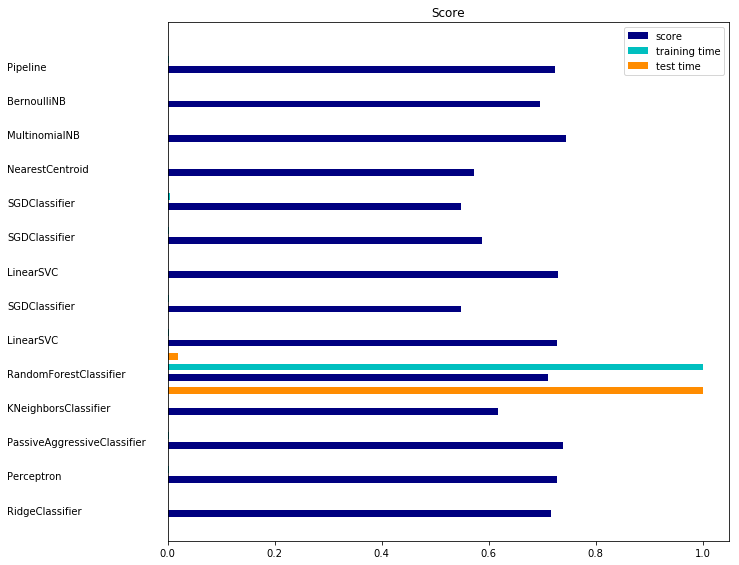

In [91]:
# Train sparse Naive Bayes classifiers
print('=' * 80)
print("Naive Bayes")
results.append(benchmark(MultinomialNB(alpha=.01)))
results.append(benchmark(BernoulliNB(alpha=.01)))

print('=' * 80)
print("LinearSVC with L1-based feature selection")
# The smaller C, the stronger the regularization.
# The more regularization, the more sparsity.
results.append(benchmark(Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False,
                                                  tol=1e-3))),
  ('classification', LinearSVC(penalty="l2"))])))

# make some plots

indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, score, .2, label="score", color='navy')
plt.barh(indices + .3, training_time, .2, label="training time",
         color='c')
plt.barh(indices + .6, test_time, .2, label="test time", color='darkorange')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.3, i, c)

plt.show()

In [87]:
type(X)

scipy.sparse.csr.csr_matrix